In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


2024-03-01 13:03:53.865309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'

pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/context_swap/')

In [3]:
result_summary = pd.read_csv('../results/summary_csvs/enformer/context_swap_test.csv')

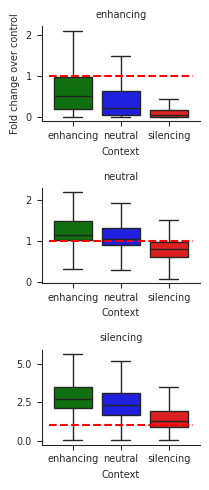

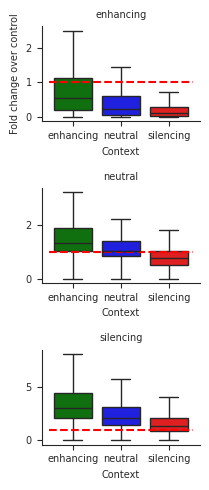

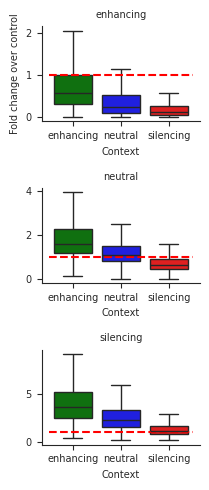

In [4]:
fontsize=7
for cell_line, dfs in result_summary.groupby('cell_line'):    
    ylims = [2, 1.5, 7.5]
    #sns.set(font_scale = .8)
    sns.set_style(style='white')
    #plt.rcParams['xtick.major.size'] = 5
    #plt.rcParams['xtick.major.width'] = 1
    
    #plt.rcParams['ytick.major.size'] = 5
    #plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
    my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
    
    fig, axes = plt.subplots(3, 1, sharey=False, figsize=[2.2, 5]) 
    
    for i, (source_context, dfs_by_content) in enumerate(dfs.groupby('source_context')):
        ax= axes[i]
        sns.boxplot(x='target_context', y='normalised', data=dfs_by_content, 
                    hue='target_context', showfliers=False, palette=my_pal, ax=ax)
        ax.set_title(source_context, fontsize=fontsize)
        x1, x2 = ax.get_xlim()
        # ax.set_ylim(0, ylims[i])
        #ax.get_legend().remove()

        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        ax.hlines(1, x1, x2, color='r', linestyles='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=fontsize)
        if i == 0:
            ax.set_ylabel('Fold change over control', fontsize=fontsize)
        else:
            ax.set_ylabel('', fontsize=fontsize)
        # add number of observations in each box
        #if cell_line !='K562':
        #    medians = dfs_by_content.groupby(['target_context'])['normalised'].median().values
        #    nobs = dfs_by_content['target_context'].value_counts().values
        #    nobs = [str(x) for x in nobs.tolist()]
        #    nobs = ["n: " + i for i in nobs]
    
            # Add it to the plot
            #pos = range(len(nobs))
            #for tick,label in zip(pos,ax.get_xticklabels()):
            #    ax.text(pos[tick],
            #            medians[tick] + 0.03,
            #            nobs[tick],
            #            horizontalalignment='center',
            #            size='x-small',
            #            color='k',
            #            weight='semibold')
       # 
        ax = plt.gca();
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()

    fig.savefig(f'{pdf_dir}/{model_name}_{cell_line}_context_swap_boxplots.pdf', format='pdf', dpi=300, bbox_inches='tight')
